# Задача 2. Линейная регрессия, метод градиентного спуска

* **Дедлайн**: 22.10.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно реализовать функцию **gradient_descent(X, y)**, которая по заданной обучающей выборке обучает модель линейной регрессии, оптимизируя функционал **методом градиентного спуска (Batch Gradient Descent, GD)** и возвращая вектор весов **w**. В качестве функционала можно выбрать, например, функцию ошибок **MSE** + $L_2$-регуляризатор. Использовать матрично-векторные операции для вычисления градиента.
- [x] Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целевого признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат. В крайнем случае взять данные для предсказания стоимости машин [тут](https://github.com/rustam-azimov/ml-course-itmo/tree/main/data/car_price) (целевой признак для предсказания --- **price**).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Случайным образом разбить данные на **обучающую** и **тестовую** выборки, используя методы существующих библиотек.
- [x] При обучении моделей использовать **масштабирование данных**.
- [x] Обучить модель на обучающей выборке, используя функцию **gradient_descent(X, y)**. Оценить качество модели на обучающей и тестовой выборках, используя **MSE**, **RMSE** и $R^2$.
- [x] Обучить модель, используя существующую библиотеку. Например, в **sklearn** для $L_2$-регуляризатора можно использовать **Ridge**. Сравнить качество с Вашей реализацией.
- [x] Повторить тоже самое, но используя **кросс-валидацию**.
- [x] Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, **E** --- мат. ожидание и **STD** --- стандартное отклонение. Сделать выводы.
- [x] * (+2 балла) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя **Recursive Feature Elimination (RFE)** из **sklearn**.
- [x] * (+1 балл) Во все ваши реализации добавить возможность настройки нужных **гиперпараметров**, а в процессе обучения **всех** моделей осуществить подбор оптимальных значений этих гиперпараметров.
- [x] * (+1 балл) Также самостоятельно реализовать **метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD)**, обучить модели и добавить их во все сравнения.
- [x] * (+1 балл) Также самостоятельно реализовать **метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent)**, обучить модели и добавить их во все сравнения.

In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Набор данных

Будет использовать https://www.kaggle.com/code/kianwee/linear-regression-insurance-dataset

Признаки:
- **age**: возраст
- **sex**: пол
- **bmi**: индекс массы тела
- **children**: количество детей
- **smoker**: курящий
- **region**: район проживания
- **charges**: медицинские расходы

Будем предсказывать медининские расходы **charges** по остальным параметрам

In [10]:
df = pd.read_csv("insurance.csv")

# EDA

In [11]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [12]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Все значения заполнены

In [13]:
df.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


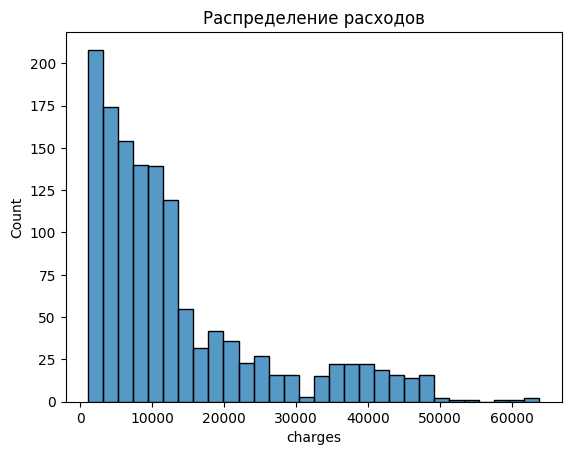

In [14]:
plt.figure()
sns.histplot(df["charges"])
plt.title("Распределение расходов")
plt.show()

Видно, что распределение асимметрично и большинство людей платят около 10k$ за страховку

Посмотрим на расходы в зависимости от пола

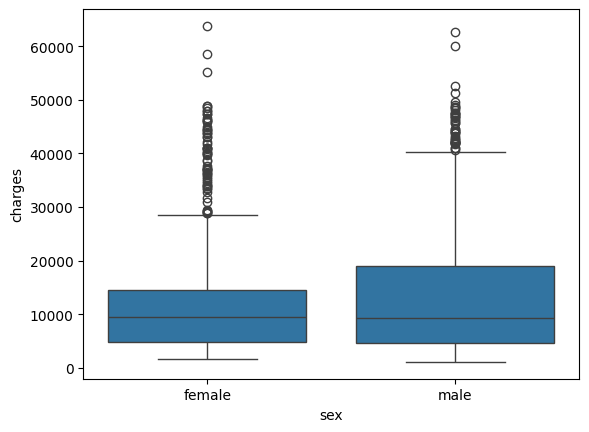

In [15]:
plt.figure()
sns.boxplot(x="sex", y="charges", data=df)
plt.show()

Видим, что у мужчин верхняя гранца интерквартильного размаха значительно больше

Также разумно, посмотреть, как зависят расходы от того, является ли человек курильщиком

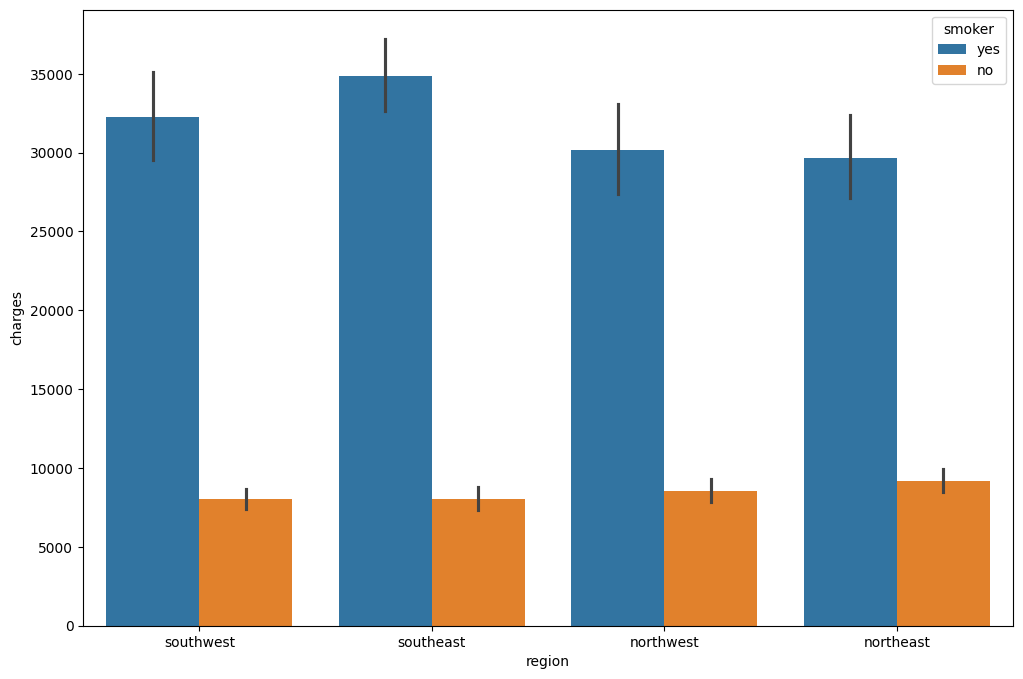

In [16]:
f, ax = plt.subplots(1,1, figsize=(12,8))
ax = sns.barplot(x = 'region', y = 'charges', hue='smoker', data=df)

Получаем довольно логичный вывод, что во всех регионах курящие платят за страховку в несколько раз больше

Из анализа выше видно, что есть 3 категориальных признака: пол, курение и регион. Закодируем

In [17]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in ['sex', 'smoker', 'region']:
    df[col] = le.fit_transform(df[col])

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


Все признаки числовые, посмотрим диаграмму корреляции

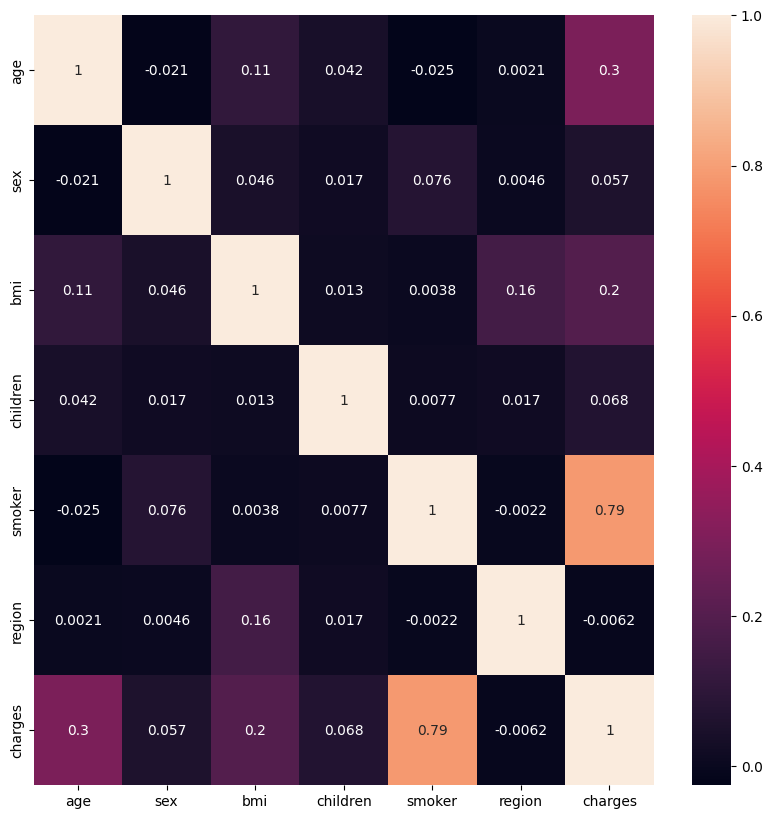

In [18]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(df.corr(), annot=True)

Как уже раннее выяснилось существует высокая корреляция между курением и стоимостью страховки, а также, тоже довольно логичные, корреляции между возрастом, ИМТ и стоимостью страховки

# **MSE** + $L_2$-регуляризатор

In [62]:
def _with_ones_vec(samples):
    samples_matrix = samples.copy()
    if samples.ndim == 1:
        samples_matrix = samples_matrix.reshape(-1, 1)

    ones_vec = np.ones((samples_matrix.shape[0], 1))
    return np.hstack([ones_vec, samples_matrix])

def linear_model(w, x):
    return np.matmul(_with_ones_vec(x), w)

def cost(w, x, y, alpha_reg):
    y_new = linear_model(w, x)
    return sum((y - y_new) ** 2) / len(y) + alpha_reg * sum(w ** 2)

# Градиентный спуск

In [63]:
class GDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2):
        self.w=None
        self.tol=tol
        self.alpha=alpha
        self.step_coef = step_coef

    def fit(self, X, y):
        features_num = np.shape(X)[1]
        X_sample = _with_ones_vec(X)
        w = np.random.randn(features_num + 1, )
        costs = []
        while True:
            y_pred = X_sample.dot(w)
            error = y_pred - y
            curr_cost = cost(w, x=X, y=y, alpha_reg=self.alpha)
            grad = (1 / X_sample.shape[0]) * (X_sample.T.dot(error) + self.alpha * w)
            w = w - self.step_coef * grad
            costs.append(curr_cost)
            if len(costs) >= 2 and abs(costs[-1] - costs[-2]) < self.tol:
                break
        self.w = w

# Стохастический градиентный спуск

In [64]:
class SGDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2, iterations_cnt=1000):
        self.w=None
        self.tol=tol
        self.alpha=alpha
        self.step_coef = step_coef
        self.iterations_cnt = iterations_cnt

    def fit(self, X, y):
        samples_num = np.shape(X)[0]
        features_num = np.shape(X)[1]
        X = np.concatenate((np.ones((samples_num, 1)), X), axis=1)
        self.w = np.random.randn(features_num + 1).reshape(features_num + 1, 1)

        for _ in range(self.iterations_cnt):
            for start in range(samples_num):
                rnd_i = np.random.randint(0, samples_num)
                x_batch, y_batch = X[rnd_i, :].reshape(1, features_num + 1), y[rnd_i].reshape(1, 1)
                y_pred = x_batch.dot(self.w)
                error = y_pred - y_batch

                gradient = (1 / x_batch.shape[0]) * (x_batch.T.dot(error) + self.alpha * self.w)
                diff = self.step_coef * gradient
                self.w -= diff

                if np.all(np.abs(diff) <= self.tol):
                    break

# Мини-пакетный градиентный спуск

In [65]:
class MiniBatchGDLinearRegression:

    def __init__(self, tol=1E-4, alpha=1, step_coef=1E-2, batch_size=10, iterations_cnt=1000):
        self.w=None
        self.tol=tol
        self.alpha=alpha
        self.step_coef = step_coef
        self.iterations_cnt = iterations_cnt
        self.batch_size = batch_size
        self.cost = 0

    def fit(self, X, y):
        samples_num = X.shape[0]
        features_num = X.shape[1]
        self.w = np.ones(features_num)

        for _ in range(self.iterations_cnt):
            for _ in range(samples_num // self.batch_size):
                batch_indexes = random.sample(range(samples_num), self.batch_size)
                x_batch, y_batch = X[batch_indexes], y[batch_indexes]
                y_pred = np.dot(x_batch, self.w) + self.cost
                error = y_batch - y_pred

                self.cost -= (-2) * self.step_coef * np.mean(error)
                gradient = (-2) * np.dot(error, x_batch)
                diff = self.step_coef * gradient
                self.w -= diff

                if np.all(abs(diff) <= self.tol):
                    return

# Train-test разбиение

In [66]:
x, y = df.drop(['charges'], axis=1), df['charges']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Масштабирование признаков

In [67]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
x_train.head()

,age,sex,bmi,children,smoker,region
0,0.472227,-1.024602,-1.756525,0.734336,-0.508747,-0.456116
1,0.543313,-1.024602,-1.033082,-0.911192,-0.508747,-1.353256
2,0.898745,-1.024602,-0.943687,-0.911192,-0.508747,0.441024
3,-0.025379,-1.024602,0.622393,3.202629,-0.508747,0.441024
4,1.040918,-1.024602,-1.504893,1.557100,-0.508747,-0.456116


# Нахождение налучшего кол-ва и подмн-ва признаков

Для подбора параметров будем использовать RFECV с линейной регрессией

In [68]:
rfecv = RFECV(estimator=LinearRegression())
rfecv.fit(x_train, y_train)

print("Оптимальное число признаков: ", rfecv.n_features_)
print("Выбранные признаки: ", *x_train.columns[rfecv.support_])

Оптимальное число признаков:  4
Выбранные признаки:  age bmi children smoker


In [69]:
bad = set(df.columns) - set(['age', 'bmi', 'children', 'smoker', 'charges'])
x_train = x_train.drop(columns=bad)
x_test = x_test.drop(columns=bad)
x_train.head()

,age,bmi,children,smoker
0,0.472227,-1.756525,0.734336,-0.508747
1,0.543313,-1.033082,-0.911192,-0.508747
2,0.898745,-0.943687,-0.911192,-0.508747
3,-0.025379,0.622393,3.202629,-0.508747
4,1.040918,-1.504893,1.557100,-0.508747


# Подбор гиперпараметров

In [70]:
alpha_grid = np.logspace(-4, 4, 10)
tol_grid = np.logspace(-4, 4, 10)

searcher = GridSearchCV(
    Ridge(),
    [{"alpha": alpha_grid, "tol": tol_grid}],
    scoring="neg_root_mean_squared_error",
    cv=5,
)
searcher.fit(x_train, y_train)

optimal_alpha = searcher.best_params_["alpha"]
optimal_tol = searcher.best_params_["tol"]

print("Best alpha = %.4f" % optimal_alpha)
print("Best tol = %.4f" % optimal_tol)

Best alpha = 0.3594
Best tol = 0.0001


In [81]:
def print_results(y_train_pred, y_test_pred):
    print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))
    print("Train RMSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=False))
    print("Test MSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=True))
    print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred, squared=True))
    print("Test MAE = %.4f" % mean_absolute_error(y_test, y_test_pred))
    print("Train MAE = %.4f" % mean_absolute_error(y_train, y_train_pred))
    print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_test_pred))
    print("Train MAPE = %.4f" % mean_absolute_percentage_error(y_train, y_train_pred))
    print("Test R^2 = %.4f" % r2_score(y_test, y_test_pred))
    print("Train R^2 = %.4f" % r2_score(y_train, y_train_pred))

# Обучение своей модели градиентного спуска

In [80]:
my_gradient_model = GDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)
my_gradient_model.fit(x_train, y_train)
my_gradient_model.w

array([13341.60868419,  3614.99791606,  1977.90069762,   519.17471925,
        9556.04377903])

In [82]:
y_train_pred1 = linear_model(my_gradient_model.w, x_train)
y_test_pred1 = linear_model(my_gradient_model.w, x_test)

print_results(y_train_pred1, y_test_pred1)

Test RMSE = 5829.3813
Train RMSE = 6113.0705
Test MSE = 33981685.8740
Train MSE = 37369631.0078
Test MAE = 4213.0873
Train MAE = 4209.9055
Test MAPE = 0.4803
Train MAPE = 0.4218
Test R^2 = 0.7811
Train R^2 = 0.7411


# Обучение библиотечной модели Ridge

In [73]:
model = Ridge(alpha=optimal_alpha, tol=optimal_tol)

model.fit(x_train, y_train)
y_train_pred2 = model.predict(x_train)
y_test_pred2 = model.predict(x_test)
model.coef_

array([3614.99791791, 1977.90069619,  519.17471834, 9556.04377991])

In [83]:
print_results(y_train_pred2, y_test_pred2)

Test RMSE = 5829.5561
Train RMSE = 6113.0689
Test MSE = 33983723.8904
Train MSE = 37369610.9280
Test MAE = 4214.3581
Train MAE = 4211.0698
Test MAPE = 0.4806
Train MAPE = 0.4221
Test R^2 = 0.7811
Train R^2 = 0.7411


# Обучение своей модели стохастического градиентного спуска

In [84]:
my_sgd_model = SGDLinearRegression(alpha=optimal_alpha, tol=optimal_tol, iterations_cnt=4000)
my_sgd_model.fit(x_train.to_numpy(), y_train.to_numpy())
my_sgd_model.w

array([[9379.0779821 ],
       [2254.81532931],
       [1190.82731898],
       [ 720.37218619],
       [6434.07514797]])

In [85]:
y_train_pred3 = linear_model(my_sgd_model.w, x_train)
y_test_pred3 = linear_model(my_sgd_model.w, x_test)
y_test_pred3 = y_test_pred3.reshape(y_test_pred3.shape[0],)

print_results(y_train_pred3, y_test_pred3)

Test RMSE = 7913.5694
Train RMSE = 8070.4922
Test MSE = 62624580.1466
Train MSE = 65132845.0464
Test MAE = 4516.0038
Train MAE = 4617.1403
Test MAPE = 0.3352
Train MAPE = 0.3161
Test R^2 = 0.5966
Train R^2 = 0.5487


Можно заметить, что у этой модели результаты значительно хуже нежели у первых двух. Вероятнее всего, качество поможет улучшить увеличение числа итераций, однако из-за этого значительно повышается время обучения

# Обучение своей модели мини-пакетного градиентного спуска

In [86]:
my_mini_batch_model = MiniBatchGDLinearRegression(batch_size=x_train.shape[0] // 50)
my_mini_batch_model.fit(x_train.to_numpy(), y_train.to_numpy())
my_mini_batch_model.w

array([3183.85056354, 3233.27900528, 1908.95612389, 9601.81027108])

In [88]:
y_train_pred4 = np.dot(x_train, my_mini_batch_model.w) + my_mini_batch_model.cost
y_test_pred4 = np.dot(x_test, my_mini_batch_model.w) + my_mini_batch_model.cost

print_results(y_train_pred4, y_test_pred4)

Test RMSE = 6136.1797
Train RMSE = 6392.8778
Test MSE = 37652700.8487
Train MSE = 40868886.6493
Test MAE = 4759.6188
Train MAE = 4776.9640
Test MAPE = 0.6398
Train MAPE = 0.5754
Test R^2 = 0.7575
Train R^2 = 0.7168


Визуализируем результаты

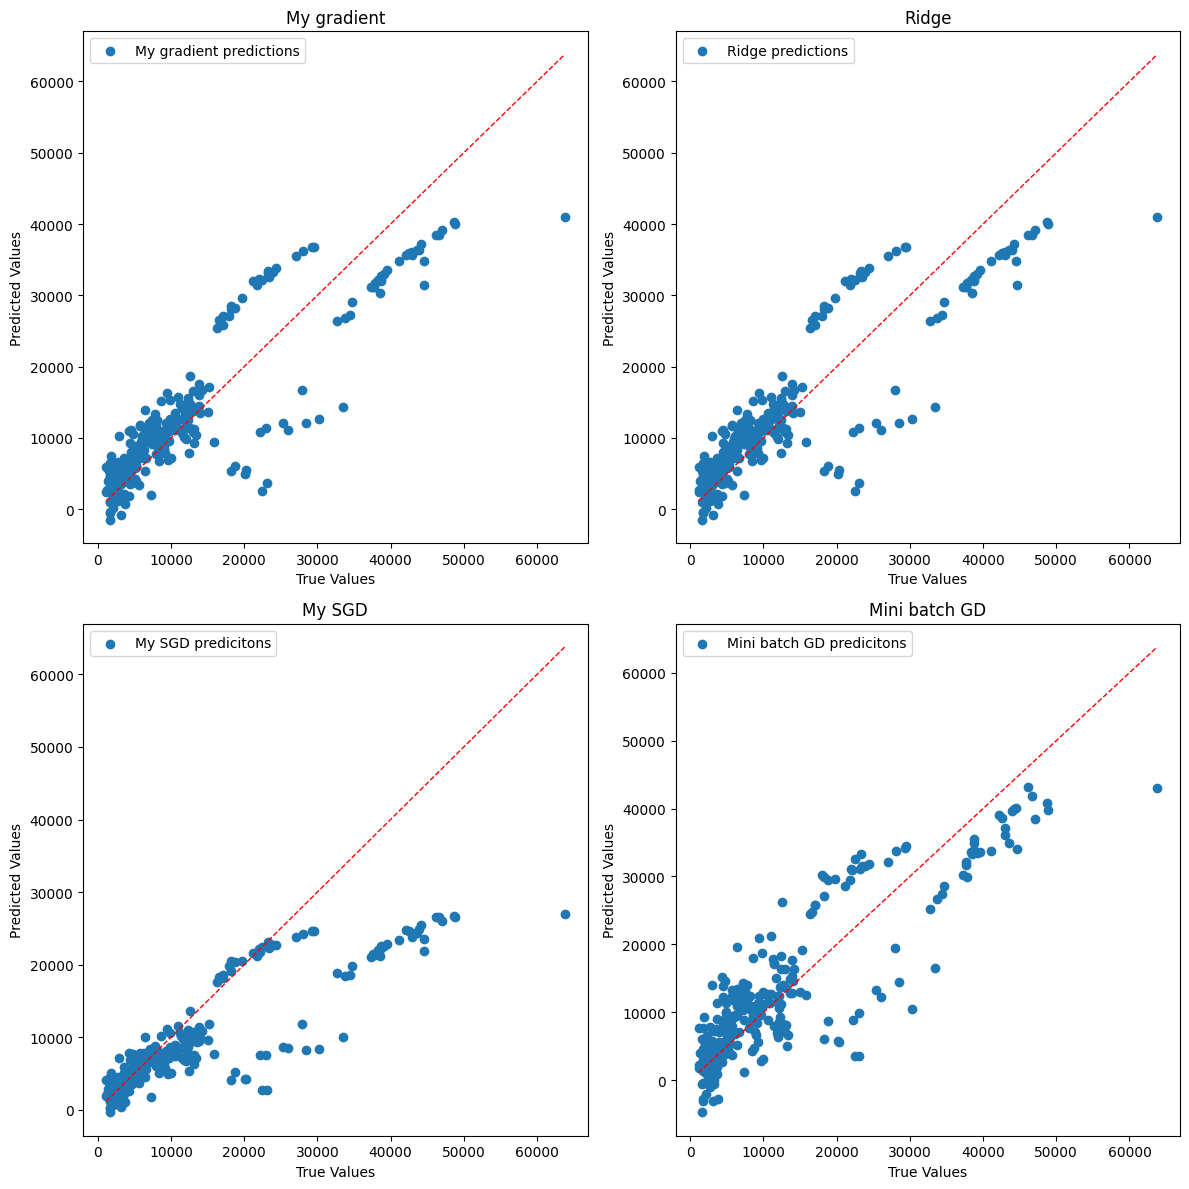

In [90]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.ravel()

ax[0].scatter(y_test, y_test_pred1, label="My gradient predictions")
ax[0].set_title("My gradient")

ax[1].scatter(y_test, y_test_pred2, label="Ridge predictions")
ax[1].set_title("Ridge")

ax[2].scatter(y_test, y_test_pred3, label="My SGD predicitons")
ax[2].set_title("My SGD")

ax[3].scatter(y_test, y_test_pred4, label="Mini batch GD predicitons")
ax[3].set_title("Mini batch GD")

for a in ax:
    a.set_xlabel("True Values")
    a.set_ylabel("Predicted Values")
    a.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linewidth=1, ls="--")
    a.legend()

plt.tight_layout()
plt.show()

Можно отметить, что для всех моделей, кроме стохастического градиентного спуска предсказания практически идентичны

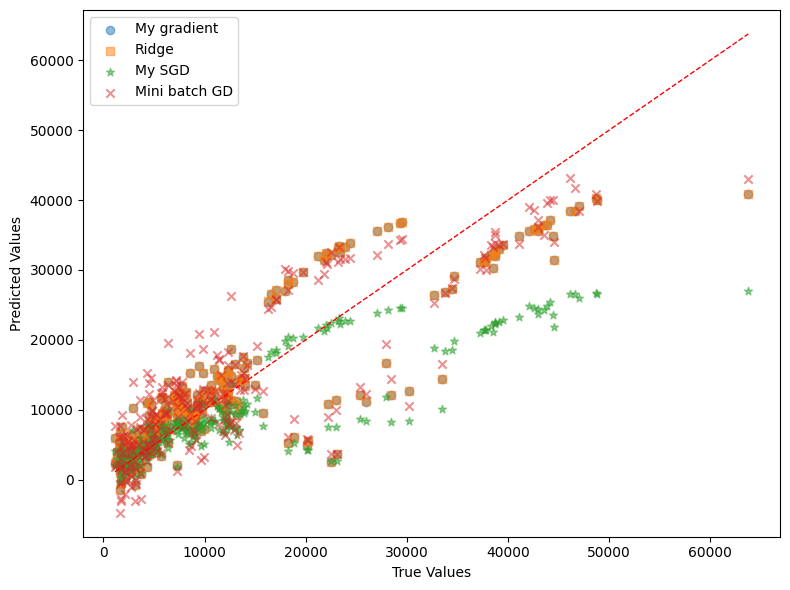

In [92]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(y_test, y_test_pred1, label="My gradient", marker="o", alpha=0.5)
ax.scatter(y_test, y_test_pred2, label="Ridge", marker="s", alpha=0.5)
ax.scatter(y_test, y_test_pred3, label="My SGD", marker="*", alpha=0.5)
ax.scatter(y_test, y_test_pred4, label="Mini batch GD", marker="x", alpha=0.5)

ax.set_xlabel("True Values")
ax.set_ylabel("Predicted Values")
ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color='red', linewidth=1, ls="--")
ax.legend()

plt.tight_layout()
plt.show()

# Кросс-валидация и таблица результатов

Собственный градиентный спуск

In [100]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train, y=y_train)

model = GDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train.iloc[train_i, :]
    cur_x_test = x_train.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    model.fit(cur_x_train, cur_y_train)
    cur_w = model.w

    y_predf_train = linear_model(cur_w, cur_x_train)
    y_predf_test = linear_model(cur_w, cur_x_test)

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

results["E"] = results.mean(axis=1)
results["STD"] = results.std(axis=1)

results

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,3.676848e+07,3.886737e+07,3.789647e+07,3.513546e+07,3.799342e+07,3.733224e+07,1.284976e+06
mse-test,3.988655e+07,3.164692e+07,3.543596e+07,4.655192e+07,3.500691e+07,3.770565e+07,5.141123e+06
rmse-train,6.063702e+03,6.234370e+03,6.156011e+03,5.927517e+03,6.163880e+03,6.109096e+03,1.057615e+02
rmse-test,6.315580e+03,5.625560e+03,5.952811e+03,6.822897e+03,5.916664e+03,6.126702e+03,4.113052e+02
r2-train,7.466002e-01,7.212669e-01,7.437455e-01,7.599628e-01,7.337844e-01,7.410720e-01,1.296088e-02
r2-test,7.175913e-01,8.047592e-01,7.266198e-01,6.581260e-01,7.669393e-01,7.348071e-01,4.933390e-02


Библиотечная модель

In [102]:
model = Ridge(alpha=optimal_alpha, tol=optimal_tol)
results = pd.DataFrame(index=[
    'mse_train', 'mse_test', 'rmse_train',  'rmse_test', 'r2_train', 'r2_test'
])

mse_train = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_squared_error")
mse_test = cross_val_score(model, x_test, y_test, cv=5, scoring="neg_mean_squared_error")
rmse_train = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
rmse_test = cross_val_score(model, x_test, y_test, cv=5, scoring="neg_root_mean_squared_error")
r2_train = cross_val_score(model, x_train, y_train, cv=5, scoring="r2")
r2_test = cross_val_score(model, x_test, y_test, cv=5, scoring="r2")

for fold_i in range(5):
    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        -mse_train[fold_i], -mse_test[fold_i], -rmse_train[fold_i], -rmse_test[fold_i], r2_train[fold_i], r2_test[fold_i]
    ])

results["E"] = results.mean(axis=1)
results["STD"] = results.std(axis=1)
results

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse_train,3.988316e+07,3.165156e+07,3.543743e+07,4.655155e+07,3.500412e+07,3.770556e+07,5.139778e+06
mse_test,2.626241e+07,3.608413e+07,3.983283e+07,4.064922e+07,3.647705e+07,3.586113e+07,5.123762e+06
rmse_train,6.315311e+03,5.625972e+03,5.952934e+03,6.822870e+03,5.916428e+03,6.126703e+03,4.111846e+02
rmse_test,5.124686e+03,6.007006e+03,6.311325e+03,6.375674e+03,6.039623e+03,5.971663e+03,4.476232e+02
r2_train,7.176153e-01,8.047305e-01,7.266085e-01,6.581288e-01,7.669579e-01,7.348082e-01,4.932606e-02
r2_test,8.450108e-01,7.184118e-01,7.450818e-01,6.817167e-01,8.116770e-01,7.603796e-01,5.996171e-02


In [106]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train, y=y_train)

model = SGDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train.iloc[train_i, :]
    cur_x_test = x_train.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    model.fit(cur_x_train.to_numpy(), cur_y_train.to_numpy())
    cur_w = model.w

    y_predf_train = linear_model(cur_w, cur_x_train)
    y_predf_test = linear_model(cur_w, cur_x_test)

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

results["E"] = results.mean(axis=1)
results["STD"] = results.std(axis=1)

results

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,5.414304e+07,5.621581e+07,5.371046e+07,4.860609e+07,5.644760e+07,5.382460e+07,2.826493e+06
mse-test,5.924906e+07,5.236580e+07,5.030923e+07,5.838595e+07,5.641216e+07,5.534444e+07,3.460130e+06
rmse-train,7.358195e+03,7.497720e+03,7.328742e+03,6.971807e+03,7.513162e+03,7.333925e+03,1.952948e+02
rmse-test,7.697341e+03,7.236422e+03,7.092900e+03,7.641070e+03,7.510803e+03,7.435707e+03,2.338790e+02
r2-train,6.268588e-01,5.968545e-01,6.368119e-01,6.679346e-01,6.044780e-01,6.265876e-01,2.524709e-02
r2-test,5.804989e-01,6.769372e-01,6.118760e-01,5.712178e-01,6.244326e-01,6.129925e-01,3.747534e-02


Построим результаты для мини-пакетного градиентного спуска

In [104]:
fold = KFold(n_splits=5)

results = pd.DataFrame(index=[
    'mse-train', 'mse-test', 'rmse-train', 'rmse-test', 'r2-train', 'r2-test'
])

splited_samples = fold.split(X=x_train, y=y_train)

model = MiniBatchGDLinearRegression(alpha=optimal_alpha, tol=optimal_tol)

for fold_i, (train_i, test_i) in enumerate(splited_samples):
    cur_x_train = x_train.iloc[train_i, :]
    cur_x_test = x_train.iloc[test_i, :]
    cur_y_train = y_train.iloc[train_i]
    cur_y_test = y_train.iloc[test_i]

    model.fit(cur_x_train.to_numpy(), cur_y_train.to_numpy())
    cur_w = model.w

    y_predf_train = np.dot(cur_x_train, model.w) + model.cost
    y_predf_test = np.dot(cur_x_test, model.w) + model.cost

    mse_train = mean_squared_error(cur_y_train, y_predf_train, squared=True)
    mse_test = mean_squared_error(cur_y_test, y_predf_test, squared=True)

    rmse_train = mean_squared_error(cur_y_train, y_predf_train, squared=False)
    rmse_test = mean_squared_error(cur_y_test, y_predf_test, squared=False)

    r2_train = r2_score(cur_y_train, y_predf_train)
    r2_test = r2_score(cur_y_test, y_predf_test)

    results.insert(loc=fold_i, column=f"Fold{fold_i + 1}", value=[
        mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test
    ])

results["E"] = results.mean(axis=1)
results["STD"] = results.std(axis=1)

results

,Fold1,Fold2,Fold3,Fold4,Fold5,E,STD
mse-train,3.996909e+07,3.972209e+07,3.971689e+07,3.635147e+07,4.165389e+07,3.948268e+07,1.724379e+06
mse-test,4.236016e+07,3.278494e+07,3.607592e+07,4.635516e+07,4.049086e+07,3.961341e+07,4.752000e+06
rmse-train,6.322111e+03,6.302546e+03,6.302133e+03,6.029218e+03,6.453983e+03,6.281998e+03,1.385014e+02
rmse-test,6.508469e+03,5.725814e+03,6.006323e+03,6.808462e+03,6.363243e+03,6.282462e+03,3.795763e+02
r2-train,7.245424e-01,7.151374e-01,7.314359e-01,7.516553e-01,7.081359e-01,7.261814e-01,1.501217e-02
r2-test,7.000774e-01,7.977383e-01,7.216826e-01,6.595711e-01,7.304296e-01,7.218998e-01,4.513396e-02


# Выводы

Мы имеем, что реализованные модели линейной регрессии с градиентным спуском и мини-пакетным градиентным спуском практически совпадают с библиотечной моделью, но всё же немного отстают на кросс-валидации
